In [1]:
import pickle
with open('ROMS_26yr_daydic.pkl', 'rb') as file:
    daydic = pickle.load(file)

with open('ROMS_26yr_eddies.pkl', 'rb') as file:
    eddies = pickle.load(file)

In [2]:
import netCDF4 as nc
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
dataset = nc.Dataset(fname)
lon_rho  = dataset.variables['lon_rho'][:]
lon_rho = np.transpose(lon_rho, axes=(1, 0))
lat_rho  = dataset.variables['lat_rho'][:]
lat_rho = np.transpose(lat_rho, axes=(1, 0))
z_r = np.load('/home/z5297792/UNSW-MRes/MRes/z_r.npy')
z_r = np.transpose(z_r, (1, 2, 0))
previous_file_idx = -1
TOTAL_NUM_DAYS = len(daydic)

In [3]:
import re
def extract_number(s):
    match = re.search(r'\d+', s)
    return int(match.group()) if match else None

def grid_finder(i_search, j_search, SEARCH_WIDTH):
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc'
    dataset = nc.Dataset(fname)
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    
    def within_search_width(i_offset, j_offset):
        return distance(lat_rho[i_search, j_search], lon_rho[i_search, j_search],
                        lat_rho[i_search + i_offset, j_search + j_offset], 
                        lon_rho[i_search + i_offset, j_search + j_offset]) < SEARCH_WIDTH / 2

    i_left, i_right = 0, 0
    j_down, j_up = 0, 0

    while i_search - i_left >= 0 and within_search_width(-i_left, 0):
        i_left += 1
    while i_search + i_right < lon_rho.shape[0] and within_search_width(i_right, 0):
        i_right += 1
    while j_search - j_down >= 0 and within_search_width(0, -j_down):
        j_down += 1
    while j_search + j_up < lon_rho.shape[1] and within_search_width(0, j_up):
        j_up += 1

    i_left = max(i_search - i_left + 1, 0)
    i_right = min(i_search + i_right, lon_rho.shape[0])
    j_down = max(j_search - j_down + 1, 0)
    j_up = min(j_search + j_up, lon_rho.shape[1])

    return i_left, i_right, j_down, j_up

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def distance(lat1, lon1, lat2, lon2):
    EARTH_RADIUS = 6357000
    lat1_rad, lon1_rad = np.radians(lat1), np.radians(lon1)
    lat2_rad, lon2_rad = np.radians(lat2), np.radians(lon2)
    dlat, dlon = lat2_rad - lat1_rad, lon2_rad - lon1_rad
    a = np.sin(dlat / 2)**2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(dlon / 2)**2
    return EARTH_RADIUS * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

def find_global_maxima(matrix):
    i_max, j_max = np.unravel_index(np.argmax(matrix, axis=None), matrix.shape)
    return i_max, j_max

def find_local_maxima(matrix):
    def is_local_maxima(matrix, i, j):
        rows, cols = matrix.shape
        value = matrix[i, j]
        if np.isnan(value):
            return False
        def is_valid_and_greater_than(value, neighbor):
            return not np.isnan(neighbor) and neighbor > value
        if i > 0 and is_valid_and_greater_than(value, matrix[i - 1, j]):
            return False
        if i < rows - 1 and is_valid_and_greater_than(value, matrix[i + 1, j]):
            return False
        if j > 0 and is_valid_and_greater_than(value, matrix[i, j - 1]):
            return False
        if j < cols - 1 and is_valid_and_greater_than(value, matrix[i, j + 1]):
            return False
        if i > 0 and j > 0 and is_valid_and_greater_than(value, matrix[i - 1, j - 1]):
            return False
        if i > 0 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i - 1, j + 1]):
            return False
        if i < rows - 1 and j > 0 and is_valid_and_greater_than(value, matrix[i + 1, j - 1]):
            return False
        if i < rows - 1 and j < cols - 1 and is_valid_and_greater_than(value, matrix[i + 1, j + 1]):
            return False
        return True
    i_max, j_max, value_max = [], [], []
    for i in range(matrix.shape[0]):
        for j in range(matrix.shape[1]):
            if is_local_maxima(matrix, i, j):
                i_max.append(i)
                j_max.append(j)
                value_max.append(matrix[i, j])
    return i_max, j_max, value_max

def eddies_nearest_rho(elon, elat):
    dataset = nc.Dataset('/srv/scratch/z3533156/26year_BRAN2020/outer_avg_01461.nc')
    lon_rho = np.transpose(dataset.variables['lon_rho'], axes=(1, 0))
    lat_rho = np.transpose(dataset.variables['lat_rho'], axes=(1, 0))
    R = np.sqrt((lon_rho - elon)**2 + (lat_rho - elat)**2)
    i_search, j_search = np.unravel_index(np.argmin(R), R.shape)
    return i_search, j_search

def get_variable_name(var):
    for name, value in globals().items():
        if value is var:
            return name
    return None

def make_cartesian(lon, lat, theta0, phi0):
    lonr = np.deg2rad(lon)
    latr = np.deg2rad(lat)
    r_earth = 6371
    x = r_earth * np.cos(phi0) * (lonr - theta0)
    y = r_earth * (latr - phi0)
    return x, y

def eddy_centric_grid_distances(i_search, j_search, i_left, i_right, j_down, j_up):
    lonc = lon_rho[i_search, j_search]
    latc = lat_rho[i_search, j_search]
    def make_left_values_negative(arr):
        zero_index = np.where(arr == 0)[0]
        if zero_index.size == 0:
            return arr
        zero_index = zero_index[0]
        arr[:zero_index] = -np.abs(arr[:zero_index])
        return arr
    x = make_left_values_negative(distance(latc, lonc, lat_rho[i_left:i_right,j_search], lon_rho[i_left:i_right,j_search]))
    y = make_left_values_negative(distance(latc, lonc, lat_rho[i_search,j_down:j_up], lon_rho[i_search,j_down:j_up]))
    return x/1000, y/1000

def rotate_30_clockwise(x, y):
    theta = np.deg2rad(30)
    rotation_matrix = np.array([
        [np.cos(theta), -np.sin(theta)],
        [np.sin(theta), np.cos(theta)]
    ])
    points = np.vstack((x, y))
    rotated_points = rotation_matrix @ points
    x_rotated, y_rotated = rotated_points
    return x_rotated, y_rotated

def extract_contour(level_to_extract, plot):
    for level_paths in plot.allsegs:
        for path in level_paths:
            xt = path[:, 0]
            yt = path[:, 1]
            return xt, yt
    else:
        return [], []

def normalize_matrix(matrix):
    matrix = np.array(matrix)
    std_dev = np.nanstd(matrix)
    normalized_matrix = matrix / std_dev
    return normalized_matrix


In [4]:
edata = eddies['Eddy17'].iloc[3] #E22T5 #E17T3
t = extract_number(edata.name)

mcolor = 'r' if edata.Vort > 0 else 'c'
colormap = 'Reds' if edata.Vort > 0 else 'Blues'

temp_ave = np.load('/srv/scratch/z5297792/Climatology/temp_ave.npy')
CurSpeed_ave = np.load('/srv/scratch/z5297792/Climatology/CurSpeed_ave.npy')

t_mod = t % 30
file_idx = np.floor(t/30)
if file_idx != previous_file_idx:
    
    fnumber = '0'+str(round(1461+ file_idx*30))
    fname = '/srv/scratch/z3533156/26year_BRAN2020/outer_avg_'+fnumber+'.nc'
    dataset = nc.Dataset(fname)
    
    U = np.load('/srv/scratch/z5297792/Climatology/u_v/u_'+fnumber+'.npy')
    V = np.load('/srv/scratch/z5297792/Climatology/u_v/v_'+fnumber+'.npy')
    Vorticity = np.load('/srv/scratch/z5297792/Climatology/vorts/vort_'+fnumber+'.npy')
    TemperatureAnomaly = np.load('/srv/scratch/z5297792/Climatology/temps/temp_'+fnumber+'.npy') - np.repeat(temp_ave[:, :, :, np.newaxis], 30, axis=3)
    CurSpeed = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/cur_speed_'+fnumber+'.npy')
    CurSpeedAnomaly = CurSpeed - np.repeat(CurSpeed_ave[:, :, :, np.newaxis], 30, axis=3)
    OW = np.load('/srv/scratch/z5297792/Climatology/ow_and_cur_speeds/ow_'+fnumber+'.npy')
    ocean_time = dataset.variables['ocean_time'][:]
    
    previous_file_idx = file_idx

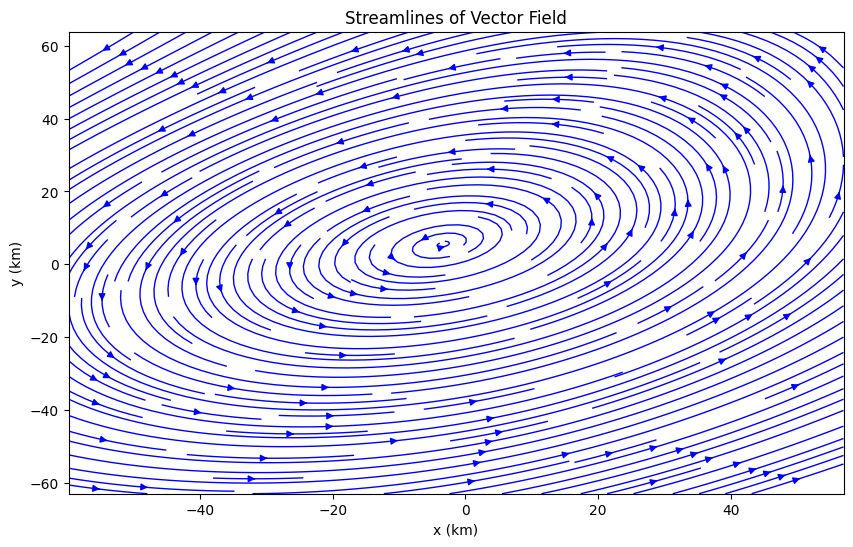

In [56]:
import matplotlib.colors as mcolors

SEARCH_WIDTH = 100000
DEPTH_LVL = 0

i_search, j_search = eddies_nearest_rho(edata.Lon, edata.Lat)
i_left, i_right, j_down, j_up = grid_finder(i_search, j_search, SEARCH_WIDTH)
u = U[i_left:i_right, j_down:j_up, DEPTH_LVL, t_mod]
v = V[i_left:i_right, j_down:j_up, DEPTH_LVL, t_mod]

lon = lon_rho[i_left:i_right, j_down:j_up]
lat = lat_rho[i_left:i_right, j_down:j_up]

x, y = make_cartesian(lon, lat, np.deg2rad(edata.Lon), np.deg2rad(edata.Lat)) # np.mean(np.deg2rad(lon)), np.mean(np.deg2rad(lat)))

X = np.linspace(x.min(), x.max(), u.shape[0])
Y = np.linspace(y.min(), y.max(), u.shape[1])

# Create a grid for plotting
X, Y = np.meshgrid(X, Y)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot streamlines
strm = plt.streamplot(X, Y, u.T, v.T, color='b', linewidth=1, density=2)

# Add labels and title
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.title('Streamlines of Vector Field')

# Show plot
plt.show()



In [16]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.streamplot import StreamplotSet
from scipy.integrate import odeint

streamline_paths = []
for line in strm.lines.get_paths():
    streamline_paths.append(line.vertices.T)


## The Curvature Center Method

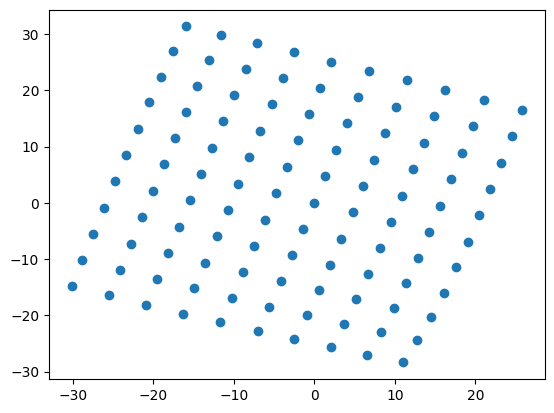

In [6]:
import numpy as np

# Compute gradients
du_dx, du_dy = np.gradient(u)
dv_dx, dv_dy = np.gradient(v)

# Calculate the curvature
curvature = (dv_dx - du_dy) / (u**2 + v**2)**(3/2)

# Avoid division by zero
curvature[np.abs(curvature) < 1e-10] = np.nan

# Calculate center of curvature
x_c = x - (v / curvature)
y_c = y + (u / curvature)

# Handle any NaN values or out-of-bounds issues as necessary

plt.scatter(x_c,y_c)

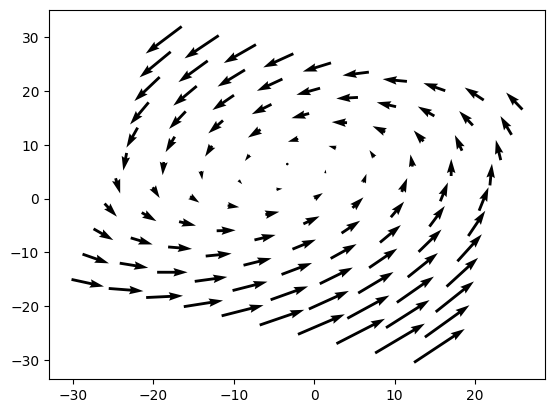

In [7]:
plt.quiver(x,y,u,v)

## The Winding-Angle Method

/scratch/pbs.5730144.kman.restech.unsw.edu.au/ipykernel_1707562/315184758.py:16: RuntimeWarning: invalid value encountered in scalar divide
  cos_theta = dot_product / (mag_BA * mag_BC)


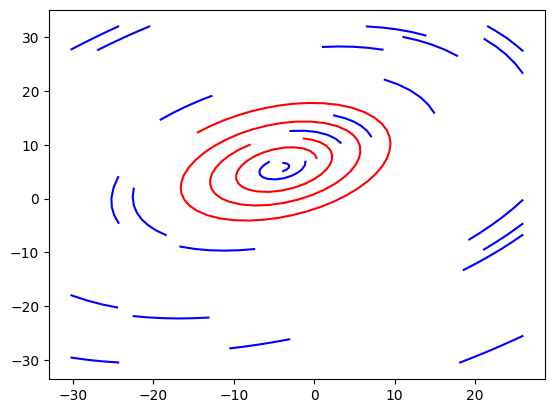

In [55]:
# Function to check if a streamline is closed
def is_closed(path, tolerance=10):
    start_point = path[:, 0]
    end_point = path[:, -1]
    return np.linalg.norm(start_point - end_point) < tolerance

def angle_between_points(A, B, C):
    x1, y1 = A
    x2, y2 = B
    x3, y3 = C
    BA = (x1 - x2, y1 - y2)
    BC = (x3 - x2, y3 - y2)
    dot_product = BA[0] * BC[0] + BA[1] * BC[1]
    mag_BA = math.sqrt(BA[0] ** 2 + BA[1] ** 2)
    mag_BC = math.sqrt(BC[0] ** 2 + BC[1] ** 2)
    cos_theta = dot_product / (mag_BA * mag_BC)
    cos_theta = max(-1, min(1, cos_theta))
    return math.degrees(math.acos(cos_theta))


# Extract closed streamlines
closed_streamlines = [path for path in streamline_paths if is_closed(path)]

# Plot closed streamlines
for path in closed_streamlines:

    xx, yy = path[0], path[1]

    winding_angle = 0
    for i in range(len(xx)):
        if i+2 < len(xx):
            A = (xx[i],yy[i])
            B = (xx[i+1],yy[i+1])
            C = (xx[i+2],yy[i+2])
            D = (2 * B[0] - A[0], 2 * B[1] - A[1]) # = 2B-A
            
            alpha = angle_between_points(D, B, C)
    
            winding_angle += alpha

    if winding_angle >= 360:
        plt.plot(path[0], path[1], 'r')  # Plot in red or any other color
    else: 
        plt.plot(path[0], path[1], 'b')  # Plot in red or any other color
    